In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC125_hmimFAP_PR import configuration
data = pd.read_csv('R125_hmimFAP.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['hmimFAP', 'R125'].fix(-0.12790)
m.fs.properties.PR_kappa_A['R125', 'hmimFAP'].fix(-0.04074)
m.fs.properties.PR_kappa_B['hmimFAP', 'R125'].fix(0.0)
m.fs.properties.PR_kappa_B['R125', 'hmimFAP'].fix(0.0)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'hmimFAP'].unfix()


In [4]:
bmim = np.linspace(data["x_hmimFAP"].iloc[6], data["x_hmimFAP"].iloc[0], 15)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R125_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "hmimFAP"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
#     print(a)
    b = 1-(bmim[i])
#     print(b)
#     P0[i] = 1817227.28*b**2 + 1070035.75*b - 17132.62 for R32
    P0[i] = 1955312.94*b**2 - 19036.50*b + 63292.70
    print(P0[i])

    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'hmimFAP'].fix(bmim[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x1[i] = "NaN"
            P[i] = "NaN"



0
705528.3712469601
1
621987.0523591312
2
544263.7870764458
3
472358.5753989028
4
406271.41732650285
5
346002.3128592457
6
291551.26199713134
7
242918.26474016008
8
200103.32108833134
9
163106.43104164573
10
131927.59460010275
11
106566.81176370283
12
87024.0825324457
13
73299.40690633141


In [5]:
print(P)
print(data["pressure"])
print(data["x_R125"])

[997362.70041908 913869.07684982 832864.79098143 754546.08326521
 678961.93479283 606072.60103614 535786.74962597 467984.96038531
 402534.51370221 339298.59765199 278141.93101058 218934.08286188
 161551.31414602 105877.47368667      0.        ]
0      50000
1     100000
2     200000
3     400000
4     600000
5     800000
6    1000000
Name: pressure, dtype: int64
0    0.038
1    0.074
2    0.142
3    0.267
4    0.380
5    0.482
6    0.578
Name: x_R125, dtype: float64


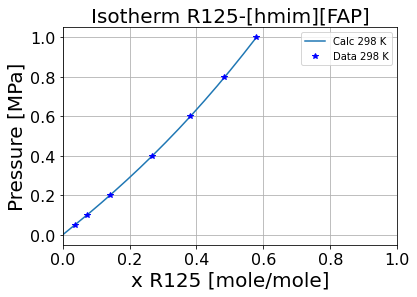

In [6]:
P1 = np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

# P1[1] = 0.6888

plt.plot(R125_x1,P1,"-",label="Calc 298 K")  
plt.plot(data["x_R125"][0:8],data["pressure"][0:8]/1e6,"*",color='b',label="Data 298 K")  
plt.title('Isotherm R125-[hmim][FAP]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R125 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.ylim(0,1.110000)
plt.xlim(0,1)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R125-[bmim][Ac]_bin.png', bbox_inches='tight',dpi=300)
plt.show()


In [7]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -470.76 : False : (None, None)
    Pressure Change :  32578. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                             Inlet  Vapor Outlet  Liquid Outlet
    flow_mol                1.0000      0.10829       0.89171  
    mole_frac_comp hmimFAP 0.82343   1.0000e-08       0.92343  
    mole_frac_comp R125    0.17657       1.0000      0.076571  
    temperature             298.00       298.00        298.00  
    pressure                73299.   1.0588e+05    1.0588e+05  


In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')